## Populate waypoints

##### October 25, 2024

### Step 1. Preparation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from PIL import Image

##### Set working directory

In [2]:
# os.chdir('./1024')
print(os.getcwd())
path = os.getcwd() + '/1024/' 
# print("\n".join(os.listdir()))

/home/misys/shared_dir


##### <u> Map info </u> - ***User Input***

In [3]:
map_name = path+'map_1024.pgm'
map_resolution = 0.05 # from the yaml file
orig_x = -5.19 # from the yaml file
orig_y = -7.79 # from the yaml file 

##### Bring the map as an image

In [4]:
raw_map_img = np.array(Image.open(map_name).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)

##### Define the function

In [5]:
def generate_waypoints(to_be_modified):
    # Load the CSV file
    df = pd.read_csv(input_raceline, header=None)

    # Extract X, Y coordinates and velocity
    x = df[0].values
    y = df[1].values
    velocity = df[2].values   

    old_x = np.copy(df[0].values)
    old_y = np.copy(df[1].values)
    old_v = np.copy(df[2].values)

    for k in to_be_modified:
        x[k] += to_be_modified[k][0]
        y[k] += to_be_modified[k][1]
        velocity[k] += to_be_modified[k][2]

    if x[0] != x[-1] and y[0] != y[-1]:
        x = np.append(x,x[0])   
        y = np.append(y,y[0])   
        velocity = np.append(velocity,velocity[0])   

    # Create a parameter t for the spline based on the index
    t = np.arange(len(x))

    # Perform cubic spline interpolation for x, y, and velocity
    cs_x = CubicSpline(t, x)
    cs_y = CubicSpline(t, y)
    cs_velocity = CubicSpline(t, velocity)

    # Generate new points for a smoother raceline
    new_t = np.linspace(0, len(x) - 1, num=num_waypoints)
    # new_t = np.linspace(0, len(x), num=num_waypoints)
    new_x = cs_x(new_t)
    new_y = cs_y(new_t)
    new_velocity = cs_velocity(new_t)

    # Optionally save new waypoints with interpolated velocities to CSV
    new_waypoints_with_velocity = np.column_stack((new_x, new_y, new_velocity))    
    np.savetxt(output_raceline, new_waypoints_with_velocity, delimiter=',')

    # calculate the distances between new points
    dx = np.diff(new_x)
    dy = np.diff(new_y)
    distances = np.sqrt(dx**2 + dy**2)

    # find max, min velocity 
    max_vel = new_velocity.max()
    min_vel = new_velocity.min()

    # scaling for plotting data
    x -= orig_x
    y -= orig_y
    x /= map_resolution
    y /= map_resolution
    old_x -= orig_x
    old_y -= orig_y
    old_x /= map_resolution
    old_y /= map_resolution
    new_x -= orig_x
    new_y -= orig_y
    new_x /= map_resolution
    new_y /= map_resolution

    # Plotting the original and interpolated raceline with velocity coloring
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.imshow(raw_map_img, cmap='gray', origin='lower')
    plt.scatter(old_x, old_y, c=old_v, cmap='Reds', label='Original Waypoints', marker = 's', s=30)
    plt.scatter(x, y, c=velocity, cmap='viridis', label='Original Waypoints', s=50)
    plt.scatter(new_x, new_y, c=new_velocity, cmap='viridis', label='Spline Approximated Waypoints', marker = '*', s=20)
    # plt.plot(new_x, new_y, '-', label='Spline Approximated Waypoints', color='orange', linewidth=2)
    plt.title('Raceline Spline Approximation with Velocity Interpolation')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')

    # Add a colorbar for velocity
    cbar = plt.colorbar()
    cbar.set_label('Velocity')

    # Add labels to the data points
    for i in range(len(df)):
        plt.annotate(str(i), (x[i], y[i]), fontsize=8, ha='right', color='red')

    # tick label in m 
    # Set x-axis grid lines at 1-meter intervals
    x_min, x_max = ax.get_xlim()
    x_ticks = np.arange(np.floor(x_min), np.ceil(x_max) + 1, 1 / map_resolution)
    ax.set_xticks(x_ticks)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x*map_resolution:.1f}m"))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y*map_resolution:.1f}m"))

    plt.show()

    return distances, max_vel, min_vel


In [6]:
def draw_waypoints(raceline):
    # Load the CSV file
    df = pd.read_csv(raceline, header=None)

    # adjust coordinate and resoultion based on the yaml file
    df -= np.array([orig_x, orig_y, 0])
    df.iloc[:, :2] /= map_resolution

    # Extract X, Y coordinates and velocity
    x = df[0].values
    y = df[1].values
    velocity = df[2].values

    # Plotting the original and interpolated raceline with velocity coloring
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.imshow(raw_map_img, cmap='gray', origin='lower')
    plt.scatter(x, y, c=velocity, cmap='viridis', label='Waypoints', s=50)
    plt.title('Raceline Spline')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')

    # Add a colorbar for velocity
    cbar = plt.colorbar()
    cbar.set_label('Velocity')

    # Add labels to the data points
    for i in range(len(df)):
        plt.annotate(str(i), (x[i], y[i]), fontsize=8, ha='right', color='red')

    # tick label in m 
    # Set x-axis grid lines at 1-meter intervals
    x_min, x_max = ax.get_xlim()
    x_ticks = np.arange(np.floor(x_min), np.ceil(x_max) + 1, 1 / map_resolution)
    ax.set_xticks(x_ticks)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x*map_resolution:.1f}m"))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y*map_resolution:.1f}m"))

    plt.show()

### Step 2. Generate waypoints from a spline approximation 

In [7]:
num_waypoints = 200

##### <u> Raceline file names </u> - ***User Input***

In [8]:
input_raceline = path+'map_1024_mu0.2.csv'
output_raceline = path+ 'map_1024_mu0.2_pop.csv'

##### <u> Points to be modified </u>  - ***User Input***

In [9]:
# the point number : (delta x, delta y, delta velocity) e.g) to_be_modified = {58:(-0.2, 0.1, 0), 59:(-0.2, -0.1, 0)} 
# to_be_modified = {58:(-0.2, 0, 0), 59:(-0.4, -0.1, 0)} 
to_be_modified = {}

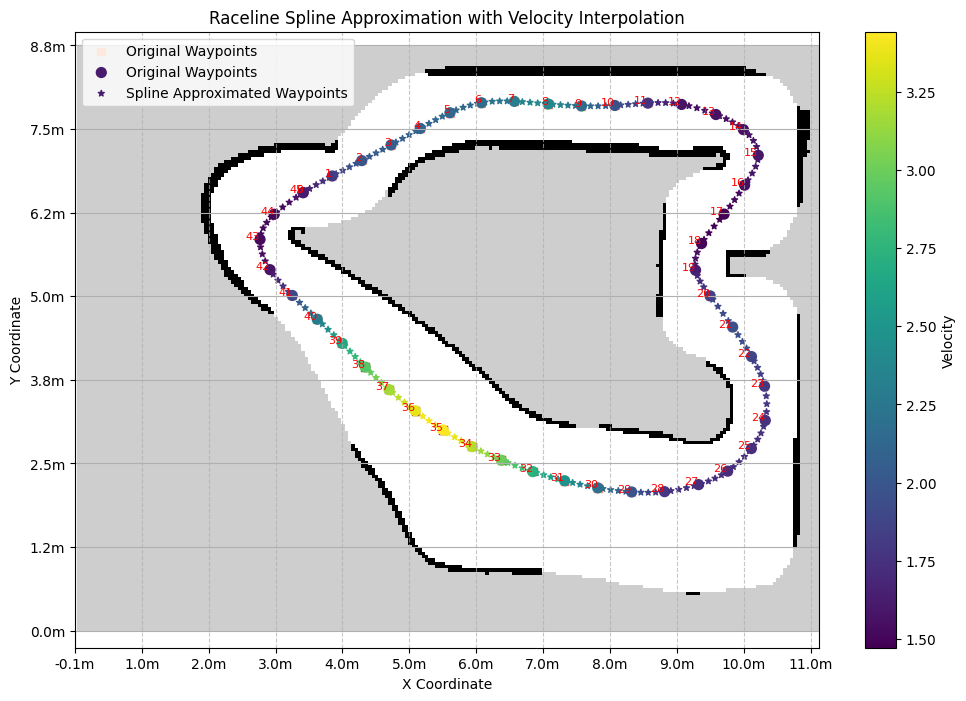

the mean distances between waypoints : 0.11288407168172032
the max and min velocity: 3.4424729087549557, 1.4716080002664147


In [10]:
distances, max_vel, min_vel = generate_waypoints(to_be_modified)
print(f'the mean distances between waypoints : { distances.mean() }')
print(f'the max and min velocity: { max_vel }, {min_vel}')

### Step 3. Examine waypoints 

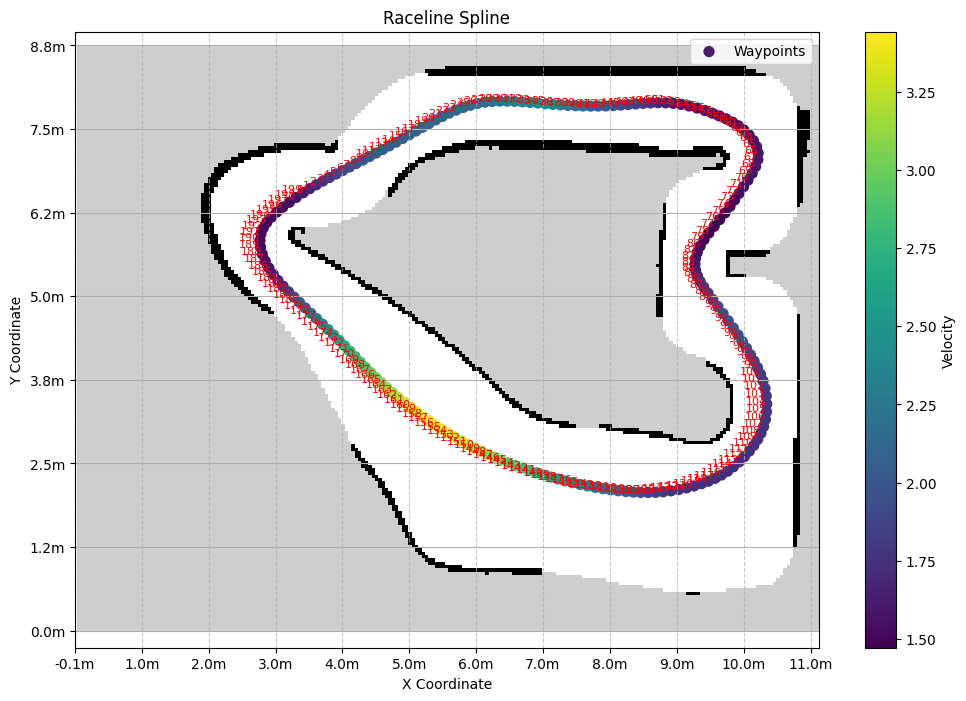

In [11]:
draw_waypoints(output_raceline)

In [12]:
output_raceline

'/home/misys/shared_dir/1024/map_1024_mu0.2_pop.csv'